In [ ]:
# pip install urllib3==1.26.15
# pip install scipy==1.12

In [1]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.tokenizer = WordPunctTokenizer()
    def preprocess_text(self, text):
        text = text.lower()
        text = emoji.demojize(text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = self.tokenizer.tokenize(text)
        tokens = [word for word in tokens if word not in self.stop_words and word.isalnum()]
        tokens = [self.lemmatize_token(word) for word in tokens]
        return tokens

    def lemmatize_token(self, token):
        tag = self.get_wordnet_pos(nltk.pos_tag([token])[0][1])
        return self.lemmatizer.lemmatize(token, pos=tag) if tag else token
    @staticmethod
    def get_wordnet_pos(treebank_tag):
        #Converts treebank tag to wordnet tag
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None

In [3]:
def preprocess(df, data_type):
    if data_type == 'comments':
        text = 'body'
    elif data_type == 'submissions':
        text = 'selftext'
    col_index = df.columns.get_loc(text) + 1
    preprocessed_text = df[text].apply(preprocessor.preprocess_text)
    df.insert(col_index, 'preprocessed_txt', preprocessed_text)
    return df

In [4]:
import pandas as pd
combined_male_comments = pd.read_csv("combined_male_comments.csv")

/var/folders/2h/v65x911156j8d_r4wnykkqrw0000gn/T/ipykernel_24649/533262394.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_male_comments = pd.read_csv("combined_male_comments.csv")


In [5]:
preprocessor = TextPreprocessor()
combined_male_comments = preprocess(combined_male_comments, 'comments')
combined_male_comments.head(10)

,body,preprocessed_txt,subreddit,link_id,retrieved_on,artist,temp_id
0,"This song is fucking magic live, when the crow...","[song, fuck, magic, live, crowd, sings, japane...",BadBunnyPR,t3_za73lr,2023-01-08 06:20:57,Bad Bunny,NaN
1,WOW Top 0.05%!! My gf was 0.1% and I thought T...,"[wow, top, 005, gf, 01, thought, elite, im, to...",BadBunnyPR,t3_z9wmhw,2023-01-08 06:19:27,Bad Bunny,NaN
2,Dude same omg \nI cant find the right mix any...,"[dude, omg, cant, find, right, mix, anywhere]",BadBunnyPR,t3_xm3rmh,2023-01-08 06:18:20,Bad Bunny,NaN
3,I’m proud to say that I’m top 0.01 percent,"[im, proud, say, im, top, 001, percent]",BadBunnyPR,t3_z9wmhw,2023-01-08 06:17:58,Bad Bunny,NaN
4,I had that in 2019,[2019],BadBunnyPR,t3_zad5e3,2023-01-08 06:16:46,Bad Bunny,NaN
5,Holyyy shit. I thought my top 1% was good. Lmao.,"[holyyy, shit, thought, top, 1, good, lmao]",BadBunnyPR,t3_zad5e3,2023-01-08 06:15:39,Bad Bunny,NaN
6,Jesus Christ. I’ve never seen anyone with a .0...,"[jesus, christ, ive, never, see, anyone, 01, a...",BadBunnyPR,t3_zad5e3,2023-01-08 06:15:10,Bad Bunny,NaN
7,"Bruv I have 49k total on Spotify this year, yo...","[bruv, 49k, total, spotify, year, single, artist]",BadBunnyPR,t3_z96g7v,2023-01-08 06:12:48,Bad Bunny,NaN
8,A friend of mine had around 145k minutes,"[friend, mine, around, 145k, minute]",BadBunnyPR,t3_zad5e3,2023-01-08 06:03:29,Bad Bunny,NaN
9,Same 🥹,[],BadBunnyPR,t3_zad5e3,2023-01-08 06:02:02,Bad Bunny,NaN


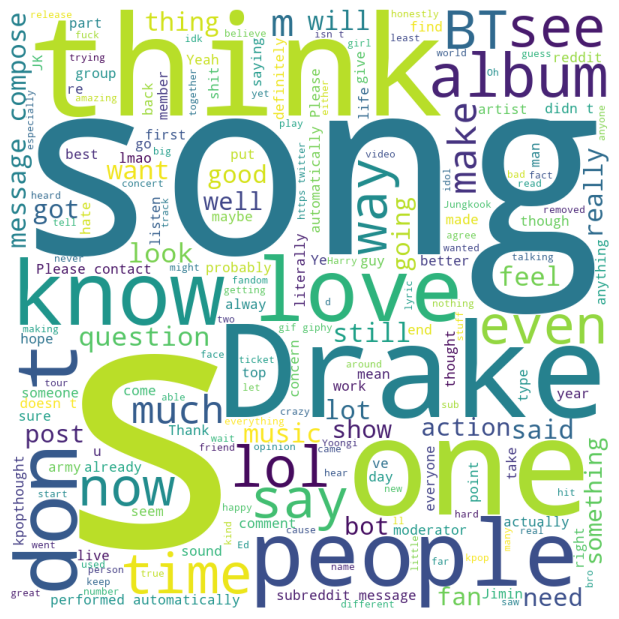

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text) 
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
text = ' '.join(combined_male_comments['body'])
plot_wordcloud(text)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def lda_topic_modeling(text, num_topics):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    data_vectorized = vectorizer.fit_transform(text)
    lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', random_state=100, n_jobs=-1)
    lda_output = lda_model.fit_transform(data_vectorized)
    return lda_model, lda_output, vectorizer

num_topics = 5
lda_model, lda_output, vectorizer = lda_topic_modeling(combined_male_comments['preprocessed_txt'].apply(lambda x: ' '.join(x)), num_topics)

In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
lol fan comment fuck yeah shit sub thank oh word
Topic 1:
song album music post love drake question listen sound perform
Topic 2:
really like bts feel year bad talk life video good
Topic 3:
make drake look want thats like big day sure im
Topic 4:
like dont think say people im time know thing come


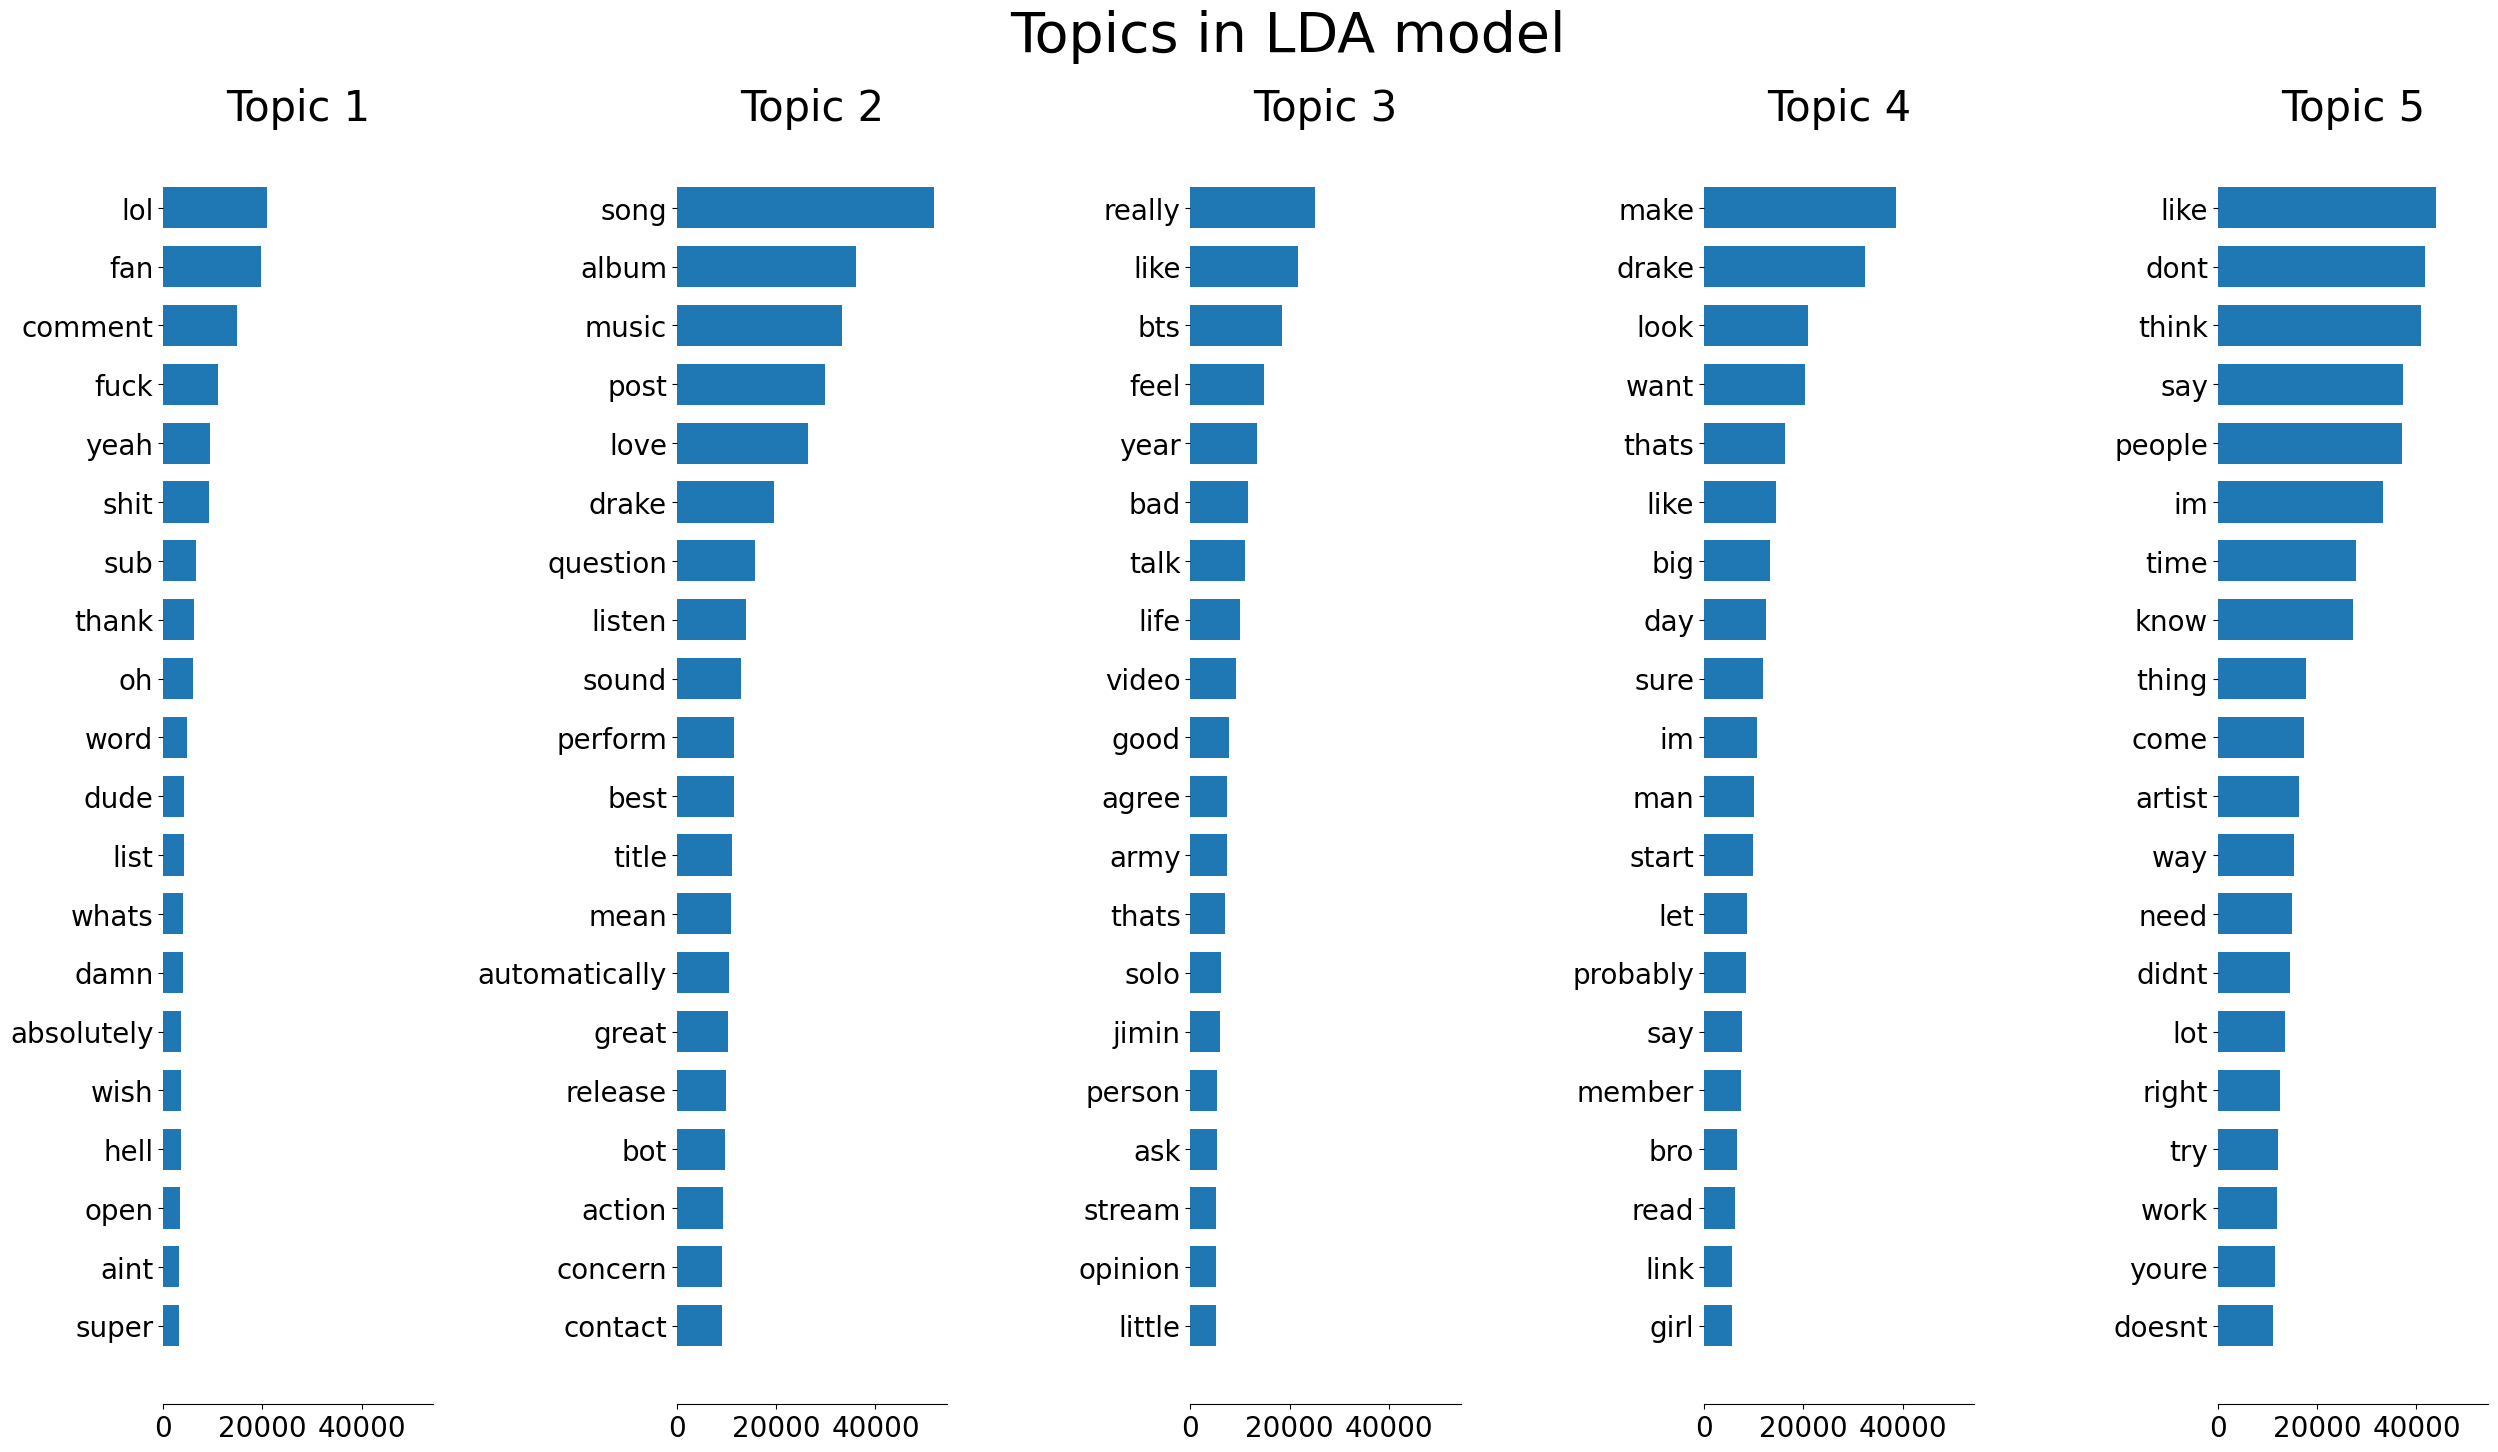

In [9]:
import matplotlib.pyplot as plt
def plot_top_words(lda_model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                      fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
n_top_words = 20
plot_top_words(lda_model, vectorizer.get_feature_names_out(), n_top_words, 'Topics in LDA model')

In [10]:
import pyLDAvis.gensim_models
from gensim import corpora
from gensim.models.ldamodel import LdaModel

def lda_topic_modeling_gensim(text, num_topics):
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(doc) for doc in text]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    return lda_model, corpus, dictionary

num_topics = 5
lda_model_gensim, corpus, dictionary = lda_topic_modeling_gensim(combined_male_comments['preprocessed_txt'], num_topics)

In [13]:
pyLDAvis.enable_notebook()
pyLDAvis_display = pyLDAvis.gensim_models.prepare(lda_model_gensim, corpus, dictionary)
pyLDAvis_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.072537 -0.412855       1        1  51.917277
2     -0.169324  0.070896       2        1  15.989701
3     -0.116343  0.122093       3        1  11.632230
0      0.396601  0.166351       4        1  10.610225
1     -0.183471  0.053515       5        1   9.850568, topic_info=           Term          Freq         Total Category  logprob  loglift
7          song  49144.000000  49144.000000  Default  30.0000  30.0000
93        music  40529.000000  40529.000000  Default  29.0000  29.0000
660        post  38865.000000  38865.000000  Default  28.0000  28.0000
255       album  38918.000000  38918.000000  Default  27.0000  27.0000
2518      title  28803.000000  28803.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
659         100   4586.641020   4710.454715   Topic5  -4.8663   2.2910
28737     jimin   9531.130426  11085.624868   Topic5  -4.1349   2.1666
2086   shipping   6833.091386   8670.540485   Topic5  -4.4677   2.0795
1776        bts  20012.659857  48726.964370   Topic5  -3.3931   1.4278
28724  jungkook   7867.989851  15227.721591   Topic5  -4.3267   1.6573

[197 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
659       4  0.026112    100
659       5  0.973791    100
330       3  0.999901      4
1041      5  0.999946      5
981       5  0.999803      6
...     ...       ...    ...
94        3  0.999922   yeah
49        2  0.999959   year
114       4  0.999880    yes
369       5  0.999978    yet
43        1  0.999957  youre

[190 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

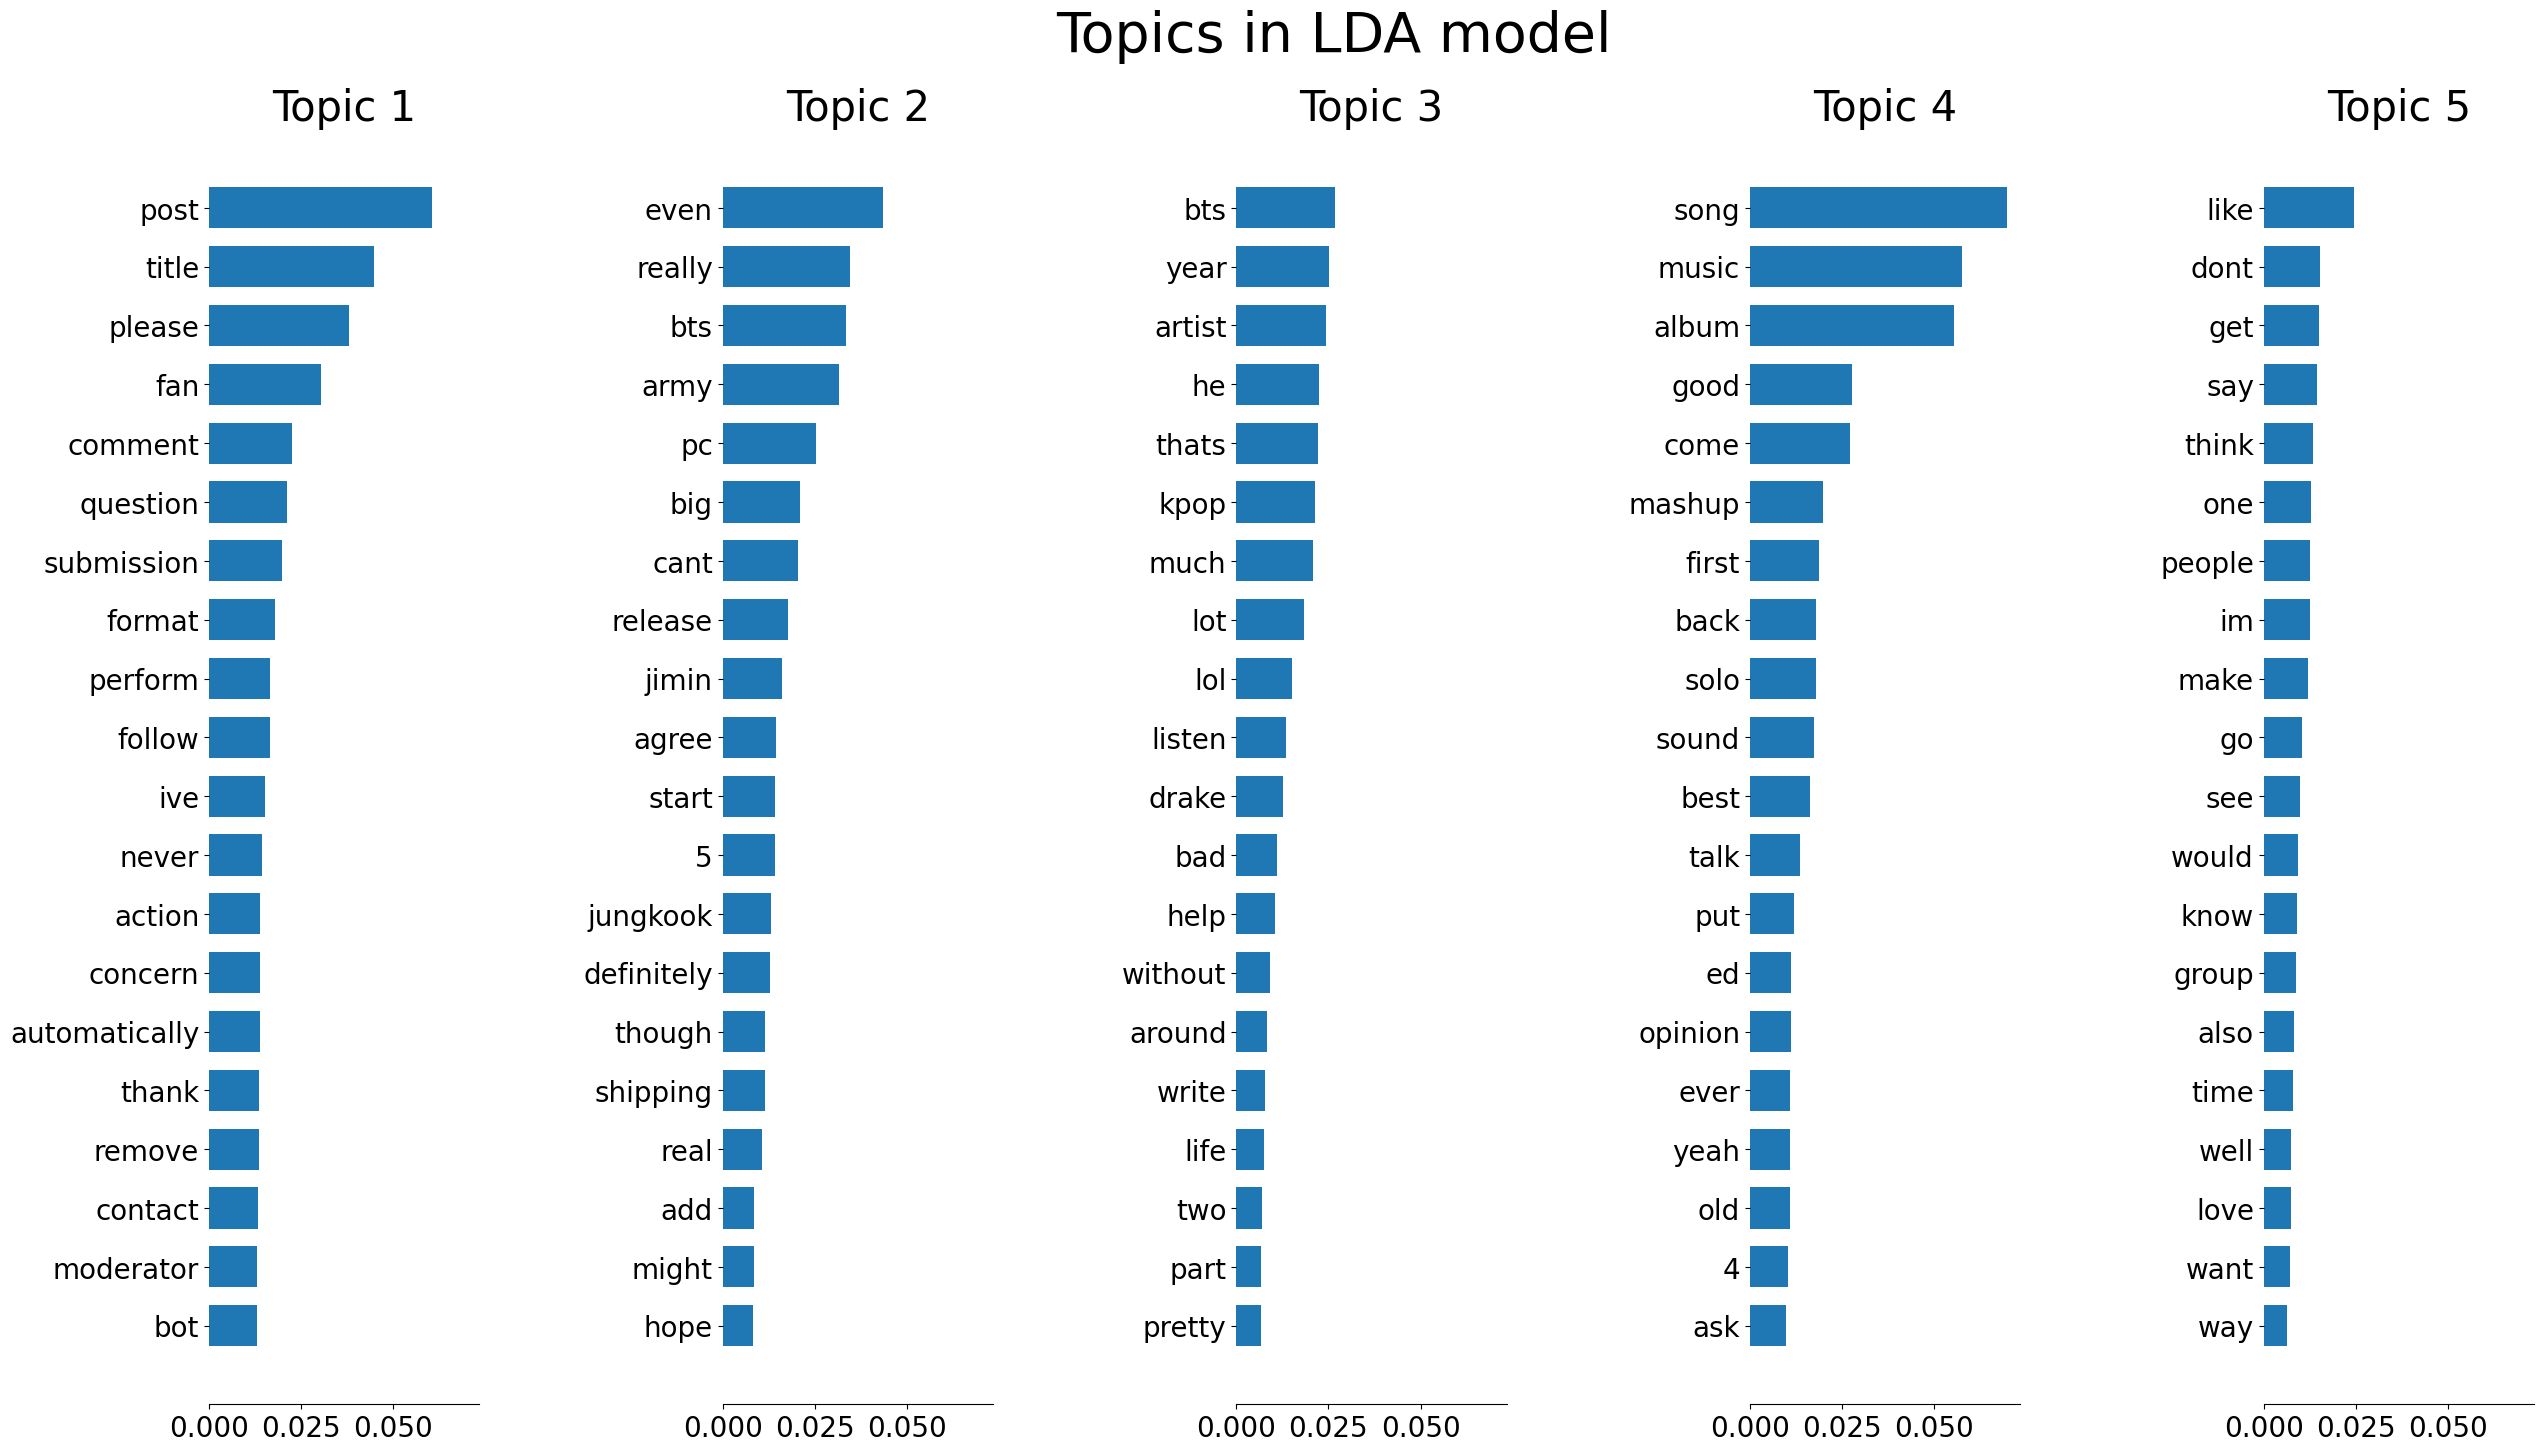

In [16]:
import matplotlib.pyplot as plt

def plot_top_words_gensim(lda_model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    topics = lda_model.get_topics()
    for topic_idx, topic in enumerate(topics):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                      fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
plot_top_words_gensim(lda_model_gensim, dictionary, n_top_words, 'Topics in LDA model')

In [17]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from guidedlda import GuidedLDA

def guided_lda_topic_modeling(text, num_topics, seed_topic_list, seed_confidence):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    data_vectorized = vectorizer.fit_transform(text)
    vocab = vectorizer.get_feature_names_out()
    word2id = dict((v, idx) for idx, v in enumerate(vocab))

    # Seed topics
    seed_topics = {}
    for t_id, st in enumerate(seed_topic_list):
        for word in st:
            seed_topics[word2id[word]] = t_id

    model = GuidedLDA(n_topics=num_topics, n_iter=100, random_state=7, refresh=20)
    model.fit(data_vectorized, seed_topics=seed_topics, seed_confidence=seed_confidence)

    return model, data_vectorized, vectorizer

seed_topic_list = [['performance'], ['outlook'], ['daily', 'life']]  # seed words for each topic
seed_confidence = 0.15  # The confidence in the seeded topics. A higher value means the seed words have more influence

num_topics = 3
guided_lda_model, data_vectorized, vectorizer = guided_lda_topic_modeling(combined_male_comments['preprocessed_txt'].apply(lambda x: ' '.join(x)), num_topics, seed_topic_list, seed_confidence)

ModuleNotFoundError: No module named 'guidedlda'

In [ ]:
# implement the BERTopic model for the preprocessed text column of the combined_male_comments dataframe
from bertopic import BERTopic

def bertopic_modeling(text, num_topics):
    model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = model.fit_transform(text)
    return model, topics, probs

num_topics = 5
bertopic_model, topics, probs = bertopic_modeling(combined_male_comments['preprocessed_txt'].apply(lambda x: ' '.join(x)), num_topics)